In [2]:
import numpy as np
import pandas
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
from config import SimulationParameters
from datetime import date, datetime, time, timedelta
from itertools import zip_longest

FEET3_S_TO_M3_S = 1 / 35.315

In [3]:
def get_simulation_data(simulation_file):
    data = np.load(simulation_file, allow_pickle=True)
    simulated_Q_m3_s = data['flume_runoff_m3_s'] * 1000
    watershed_id = data['watershed']
    precipitation_event_date = data['event_date']
    precipitation_event_start_time = data['event_start_time'].item()
    delta_time = data['timestep_delta_s']
    delta_space = data['dem_cell_size_m']
    iterations = data['iterations']
    
def compute_runoff_precipitation_time_diff_s(runoff_time : time, precipitation_time : time):
    today = datetime.today()
    runoff_event_datetime = datetime.combine(today, runoff_time)
    precipitation_event_datetime = datetime.combine(today, precipitation_time)
    precipitation_event_datetime = datetime.combine(
        today, precipitation_event_start_time)
    return (runoff_event_datetime - precipitation_event_datetime).total_seconds()

def plot_Q(X, Y, labels, colors = [], xlabel = '', ylabel = '', title = ''):
    for x,y,l,c in zip_longest(X, Y, labels, colors):
        plt.plot(x, y, label= l, color = c)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

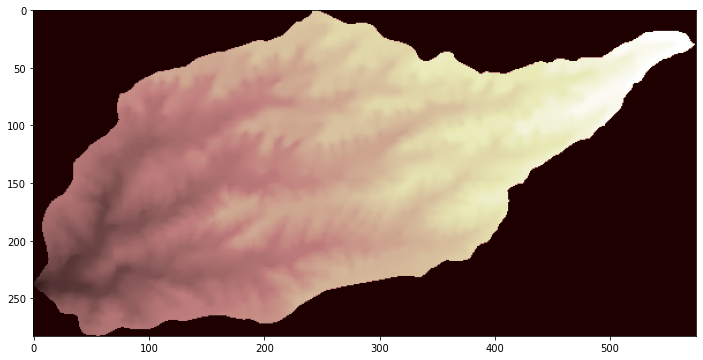

In [4]:
import rasterio as rio
dem = rio.open('watersheds/11/dem.tif')
altitude = np.array(dem.read(1).astype('float32'))
plt.imshow(altitude, cmap='pink')

In [5]:
animation_data = np.load('run_data/made_for_animation.npz', allow_pickle=True)
animation_data_Q = animation_data['water_history']
simulation_duration = animation_data['iterations'] * animation_data['timestep_delta_s']
frames_per_second = simulation_duration / animation_data_Q.shape[0]
frame = animation_data_Q[int(frames_per_second * 3600), :, :]
del animation_data_Q, animation_data

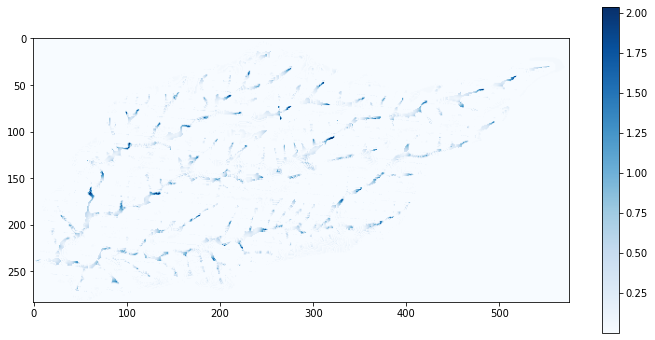

In [ ]:

plt.imshow(frame, cmap='Blues', vmax=frame.max() * .75)
plt.colorbar()


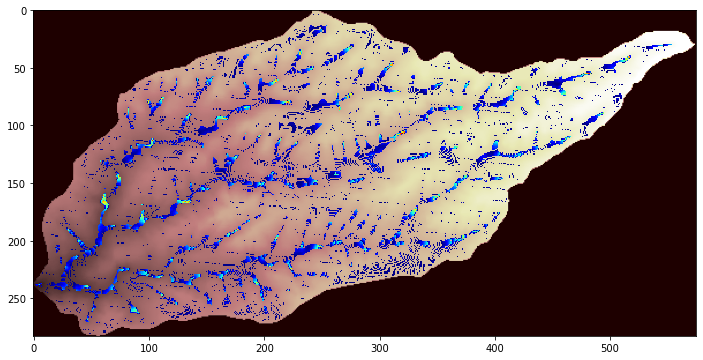

In [ ]:
import matplotlib.cm as cm

fig, ax = plt.subplots()
water_mask = np.ma.masked_where(frame < 0.05, frame)

ax.imshow(altitude, cmap=cm.pink)
ax.imshow(water_mask, cmap = cm.jet, interpolation='none')
plt.show()


## Parametri presi dal paper
Valutiamo la mia implementazione utilizzando gli stessi parametri del paper

In [ ]:
paper_like_data = np.load('run_data/paper_sim_2_params.npz', allow_pickle = True)
simulated_Q_m3_s = paper_like_data['flume_runoff_m3_s'] * 1000


watershed_id = paper_like_data['watershed']
precipitation_event_date = paper_like_data['event_date']
precipitation_event_start_time = paper_like_data['event_start_time'].item()
delta_time = paper_like_data['timestep_delta_s']
delta_space = paper_like_data['dem_cell_size_m']
iterations = paper_like_data['iterations']
manning_n = paper_like_data['manning_n']
precipitation_coverage = paper_like_data['precipitation_coverage']
infiltration_rate = paper_like_data['infiltration_rate_mm_s']

simulation_duration = iterations * delta_time
simulated_Q_time = np.arange(
                simulated_Q_m3_s.shape[0]) * simulation_duration / simulated_Q_m3_s.shape[0]

simulation_parameters = SimulationParameters(
    watershed=watershed_id, event_date=precipitation_event_date, manning_n=manning_n,
    precipitation_coverage=precipitation_coverage, timestep_delta_s=delta_time,
    dem_cell_size_m=delta_space, infiltration_rate_mm_s=infiltration_rate)

real_runoff_data = pandas.read_csv(simulation_parameters.get_runoff_data_filename())
print(simulation_parameters)



    Watershed: 11
    Event: 1980_8_4
    Manning N: 0.02
    Precipitation coverage: 1
    Delta t: 0.25
    Infiltration Rate (mm/s): 0.00216667
        


In [ ]:
real_Q_m3_s = real_runoff_data['Runoff Rate (f3/s)'] * FEET3_S_TO_M3_S
real_Q_time_s = real_runoff_data['Elapsed Time'] * 60

#Need to offset real data's time since its starting time begins after the precipitation event
hh, mm = list(map(int, real_runoff_data['Start Time'][0].split(':')))
runoff_precip_time_delta = compute_runoff_precipitation_time_diff_s(time(hh, mm), precipitation_event_start_time)
real_Q_time_s += runoff_precip_time_delta


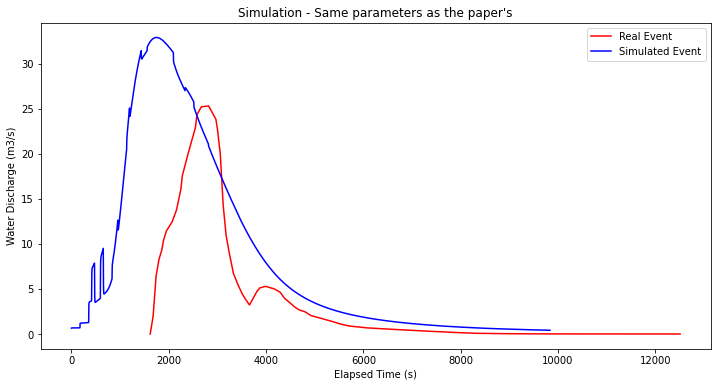

In [ ]:
plt.plot(real_Q_time_s, real_Q_m3_s, 'r', label="Real Event")
plt.plot(simulated_Q_time, simulated_Q_m3_s, 'b', label="Simulated Event")
plt.title('Simulation - Same parameters as the paper\'s')
plt.ylabel('Water Discharge (m3/s)')
plt.xlabel('Elapsed Time (s)')
plt.legend()


In [ ]:
simulated_peak_time = simulated_Q_time[np.argmax(simulated_Q_m3_s)]
real_peak_time = real_Q_time_s[np.argmax(real_Q_m3_s)]
delta = timedelta(seconds=np.abs(simulated_peak_time - real_peak_time))
print(f'Peak difference is: {delta}')
print(
    f'Peak Q value difference: {np.abs(simulated_Q_m3_s.max() - real_Q_m3_s.max())}m')


Peak difference is: 0:17:50
Peak Q value difference: 7.596118496545529m


Il modello ottiene una differenza di tempo tra i picchi di circa 18 minuti, analogamente a quanto accade nel paper (17 minuti). Per quanto riguarda la portata del picco, la simulazione, con i parametri usati, eccede di molto i risultati del paper e l'evento simulato.

La mia simulazione, con il coefficiente di Manning-Glaucker migliore trovato, anticipa il picco di soli 5 minuti rispetto all'evento reale.

In [ ]:
data = np.load('run_data/man_038_p_1_IR_001.npz', allow_pickle=True)
simulated_Q_m3_s = data['flume_runoff_m3_s'] * 1000


watershed_id = data['watershed']
precipitation_event_date = data['event_date']
precipitation_event_start_time = data['event_start_time'].item()
delta_time = data['timestep_delta_s']
delta_space = data['dem_cell_size_m']
iterations = data['iterations']
manning_n = data['manning_n']
precipitation_coverage = data['precipitation_coverage']
infiltration_rate = data['infiltration_rate_mm_s']

simulation_duration = iterations * delta_time
simulated_Q_time = np.arange(
    simulated_Q_m3_s.shape[0]) * simulation_duration / simulated_Q_m3_s.shape[0]

simulation_parameters = SimulationParameters(
    watershed=watershed_id, event_date=precipitation_event_date,
    manning_n=manning_n, precipitation_coverage=precipitation_coverage,
    timestep_delta_s=delta_time, dem_cell_size_m=delta_space,
    infiltration_rate_mm_s=infiltration_rate)

print(simulation_parameters)



    Watershed: 11
    Event: 1980_8_4
    Manning N: 0.038
    Precipitation coverage: 1
    Delta t: 0.5
    Infiltration Rate (mm/s): 0.001
        


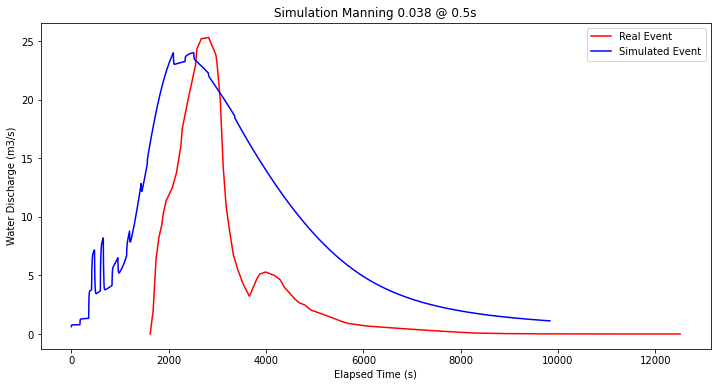

In [ ]:
real_Q_time_s = real_runoff_data['Elapsed Time'] * 60
hh, mm = list(map(int, real_runoff_data['Start Time'][0].split(':')))
runoff_precip_time_delta = compute_runoff_precipitation_time_diff_s(
    time(hh, mm), precipitation_event_start_time)

real_Q_time_s += runoff_precip_time_delta
plt.plot(real_Q_time_s, real_Q_m3_s, 'r', label="Real Event")
plt.plot(simulated_Q_time, simulated_Q_m3_s, 'b', label="Simulated Event")
plt.title(f'Simulation Manning {simulation_parameters.manning_n} @ {simulation_parameters.timestep_delta_s}s')
plt.ylabel('Water Discharge (m3/s)')
plt.xlabel('Elapsed Time (s)')
plt.legend()


In [ ]:
simulated_peak_time = simulated_Q_time[np.argmax(simulated_Q_m3_s)]
real_peak_time = real_Q_time_s[np.argmax(real_Q_m3_s)]
delta = timedelta(seconds=np.abs(simulated_peak_time - real_peak_time))
Q_delta = np.abs(simulated_Q_m3_s.max() - real_Q_m3_s.max())
print(f'Peak time difference is: {delta}')
print(f'Peak value difference is: {Q_delta}m')


Peak time difference is: 0:05:05
Peak value difference is: 1.308790637365604m


## Variabilita' dei parametri

### Timestep
Manning 0.04  
Infiltration Rate 0  
Precipitation Coverage 100%


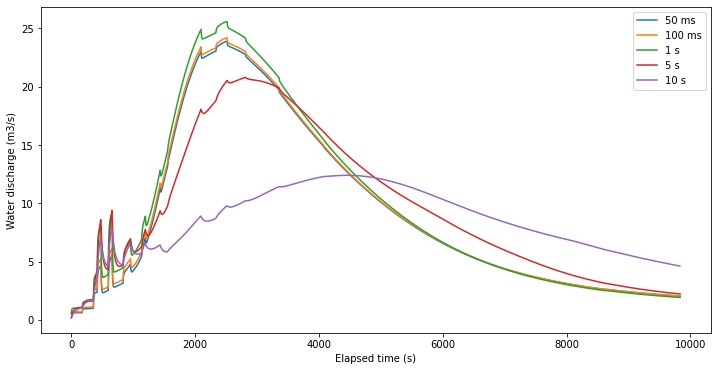

In [ ]:
sim_data_50ms = np.load('run_data/04_manning_50ms.npz', allow_pickle=True)
sim_data_100ms = np.load('run_data/04_manning_100ms.npz', allow_pickle=True)
sim_data_5s = np.load('run_data/04_manning_5s.npz', allow_pickle=True)
sim_data_1s = np.load('run_data/04_manning.npz', allow_pickle=True)
sim_data_10s = np.load('run_data/04_manning_10s.npz', allow_pickle=True)

Q_50ms = sim_data_50ms['flume_runoff_m3_s'] * 1000
Q_100ms = sim_data_100ms['flume_runoff_m3_s'] * 1000
Q_1s = sim_data_1s['flume_runoff_m3_s'] * 1000
Q_5s = sim_data_5s['flume_runoff_m3_s'] * 1000
Q_10s = sim_data_10s['flume_runoff_m3_s'] * 1000

Q_50ms_time = np.arange(Q_50ms.shape[0], dtype=np.float32)
Q_100ms_time = np.arange(Q_100ms.shape[0], dtype=np.float32)
Q_1s_time = np.arange(Q_1s.shape[0], dtype=np.float32)
Q_5s_time = np.arange(Q_5s.shape[0], dtype=np.float32)
Q_10s_time = np.arange(Q_10s.shape[0], dtype=np.float32)

sim_50ms_duration = sim_data_50ms['timestep_delta_s'] * sim_data_50ms['iterations']
sim_100ms_duration = sim_data_100ms['timestep_delta_s'] * sim_data_100ms['iterations']
sim_1s_duration = sim_data_1s['timestep_delta_s'] * sim_data_1s['iterations']
sim_5s_duration = sim_data_5s['timestep_delta_s'] * sim_data_5s['iterations']
sim_10s_duration = sim_data_10s['timestep_delta_s'] * sim_data_10s['iterations']

Q_50ms_time *= sim_50ms_duration / Q_50ms_time.shape[0]
Q_100ms_time *= sim_100ms_duration / Q_100ms_time.shape[0]
Q_1s_time *= sim_1s_duration / Q_1s_time.shape[0]
Q_5s_time *= sim_5s_duration / Q_5s_time.shape[0]
Q_10s_time *= sim_10s_duration / Q_10s_time.shape[0]

plot_Q([
    Q_50ms_time,
    Q_100ms_time,
    Q_1s_time,
    Q_5s_time,
    Q_10s_time
],
    [
    Q_50ms,
    Q_100ms,
    Q_1s,
    Q_5s,
    Q_10s
],
    [
    "50 ms",
    "100 ms",
    "1 s",
    "5 s",
    "10 s"
],
    xlabel='Elapsed time (s)',
    ylabel='Water discharge (m3/s)'
)



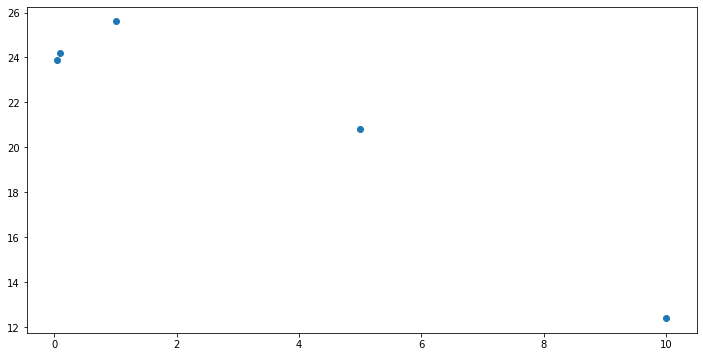

In [ ]:
Q_50ms_peak_value = Q_50ms.max()
Q_100ms_peak_value = Q_100ms.max()
Q_1s_peak_value = Q_1s.max()
Q_5s_peak_value = Q_5s.max()
Q_10s_peak_value = Q_10s.max()

X = [
    sim_data_50ms['timestep_delta_s'],
    sim_data_100ms['timestep_delta_s'],
    sim_data_1s['timestep_delta_s'],
    sim_data_5s['timestep_delta_s'],
    sim_data_10s['timestep_delta_s']
]

Y = [
    Q_50ms_peak_value,
    Q_100ms_peak_value,
    Q_1s_peak_value,
    Q_5s_peak_value,
    Q_10s_peak_value
]


plt.scatter(X, Y)

### Precipitation coverage

Text(0, 0.5, 'Water discharge (m3/s)')

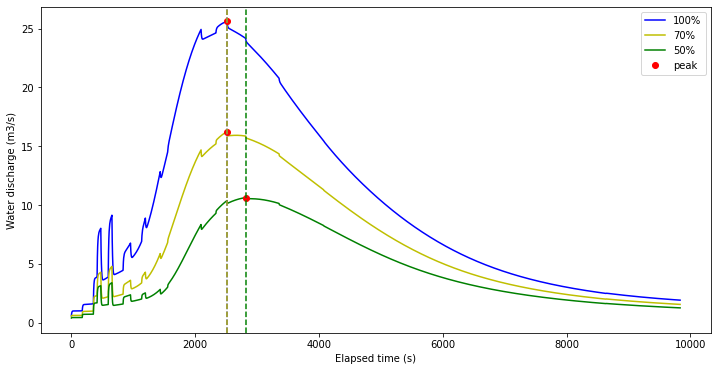

In [ ]:
sim_data_100_coverage = np.load('run_data/04_manning.npz', allow_pickle=True)
sim_data_70_coverage = np.load('run_data/04_manning_7_precipitation.npz', allow_pickle=True)
sim_data_50_coverage = np.load('run_data/04_manning_5_p.npz', allow_pickle=True)

sim_Q_100_coverage = sim_data_100_coverage['flume_runoff_m3_s'] * 1000
sim_Q_70_coverage = sim_data_70_coverage['flume_runoff_m3_s'] * 1000
sim_Q_50_coverage = sim_data_50_coverage['flume_runoff_m3_s'] * 1000

Q_100_coverage_time = np.arange(sim_Q_100_coverage.shape[0], dtype=np.float32)
Q_70_coverage_time = np.arange(sim_Q_70_coverage.shape[0], dtype=np.float32)
Q_50_coverage_time = np.arange(sim_Q_50_coverage.shape[0], dtype=np.float32)

sim_Q_100_coverage_duration_seconds = sim_data_100_coverage['iterations'] * sim_data_100_coverage['timestep_delta_s']
sim_Q_70_coverage_duration_seconds = sim_data_70_coverage['iterations'] * sim_data_70_coverage['timestep_delta_s']
sim_Q_50_coverage_duration_seconds = sim_data_50_coverage['iterations'] * sim_data_50_coverage['timestep_delta_s']

Q_100_coverage_time *= sim_Q_100_coverage_duration_seconds / Q_100_coverage_time.shape[0]
Q_70_coverage_time *= sim_Q_70_coverage_duration_seconds / Q_70_coverage_time.shape[0]
Q_50_coverage_time *= sim_Q_50_coverage_duration_seconds / Q_50_coverage_time.shape[0]

peak_100_time = Q_100_coverage_time[np.argmax(sim_Q_100_coverage)]
peak_70_time = Q_70_coverage_time[np.argmax(sim_Q_70_coverage)]
peak_50_time = Q_50_coverage_time[np.argmax(sim_Q_50_coverage)]

plt.plot(Q_100_coverage_time, sim_Q_100_coverage, label='100%', color='b')
plt.plot(Q_70_coverage_time, sim_Q_70_coverage, label='70%', color='y')
plt.plot(Q_50_coverage_time, sim_Q_50_coverage, label='50%', color='g')

plt.plot(peak_100_time, sim_Q_100_coverage.max(), 'ro', label='peak')
plt.plot(peak_70_time, sim_Q_70_coverage.max(), 'ro')
plt.plot(peak_50_time, sim_Q_50_coverage.max(), 'ro')

plt.axvline(peak_100_time, color='b', ls = '--')
plt.axvline(peak_70_time, color='y', ls = '--')
plt.axvline(peak_50_time, color='g', ls = '--')




plt.legend()
plt.xlabel('Elapsed time (s)')
plt.ylabel('Water discharge (m3/s)')


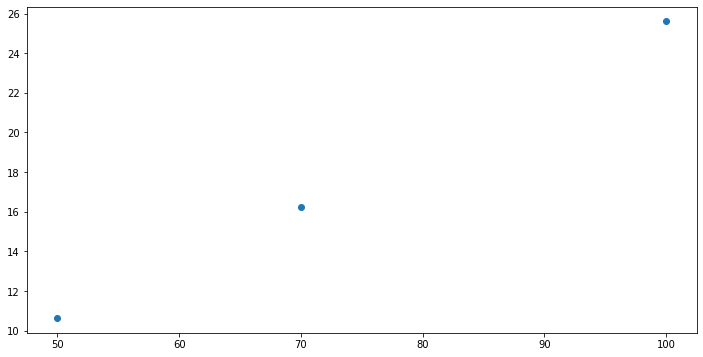

In [ ]:
Y = [
    sim_Q_100_coverage.max(),
    sim_Q_70_coverage.max(),
    sim_Q_50_coverage.max()
]

X = [
    100,
    70,
    50
]

plt.scatter(X, Y)

In [ ]:
peak_100 = Q_100_coverage_time[np.argmax(sim_Q_100_coverage)]
peak_70 = Q_70_coverage_time[np.argmax(sim_Q_70_coverage)]
peak_50 = Q_50_coverage_time[np.argmax(sim_Q_50_coverage)]


print(peak_100)
print(peak_70)
print(peak_50)


2515.0
2515.0
2815.0


### Infiltration rate

Text(0, 0.5, 'Discharge (m3/s)')

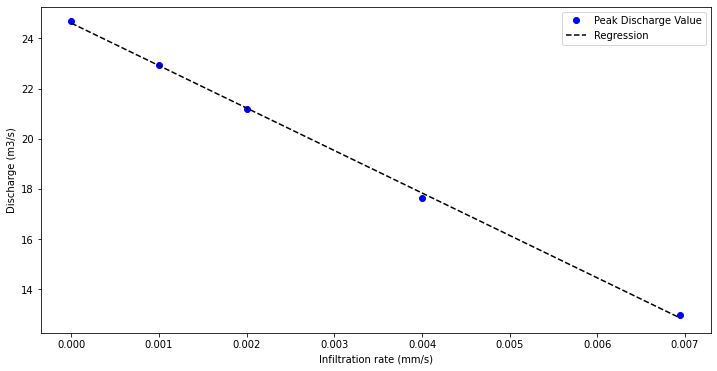

In [ ]:
sim_data_002_infiltration_rate = np.load('run_data/infiltration_rate_variability/002.npz', allow_pickle=True)
sim_data_001_infiltration_rate = np.load('run_data/infiltration_rate_variability/001.npz', allow_pickle=True)
sim_data_000_infiltration_rate = np.load('run_data/infiltration_rate_variability/0.npz', allow_pickle=True)
sim_data_0069_infiltration_rate = np.load('run_data/infiltration_rate_variability/0069.npz', allow_pickle=True)
sim_data_004_infiltration_rate = np.load('run_data/infiltration_rate_variability/004.npz', allow_pickle=True)

duration_seconds = sim_data_002_infiltration_rate['iterations'] * sim_data_002_infiltration_rate['timestep_delta_s']
sim_time = np.arange(sim_data_002_infiltration_rate['flume_runoff_m3_s'].shape[0], dtype=np.float32)
sim_time *= duration_seconds / sim_time.shape[0]


sim_data_002_Q = sim_data_002_infiltration_rate['flume_runoff_m3_s']
sim_data_001_Q = sim_data_001_infiltration_rate['flume_runoff_m3_s']
sim_data_000_Q = sim_data_000_infiltration_rate['flume_runoff_m3_s']
sim_data_0069_Q = sim_data_0069_infiltration_rate['flume_runoff_m3_s']
sim_data_004_Q = sim_data_004_infiltration_rate['flume_runoff_m3_s']

sim_data_002_Q_peak = sim_data_002_Q.max() * 1000
sim_data_001_Q_peak = sim_data_001_Q.max() * 1000
sim_data_000_Q_peak = sim_data_000_Q.max() * 1000
sim_data_0069_Q_peak = sim_data_0069_Q.max() * 1000
sim_data_004_Q_peak = sim_data_004_Q.max() * 1000

sim_data_002_IR = sim_data_002_infiltration_rate['infiltration_rate_mm_s']
sim_data_001_IR = sim_data_001_infiltration_rate['infiltration_rate_mm_s']
sim_data_000_IR = sim_data_000_infiltration_rate['infiltration_rate_mm_s']
sim_data_0069_IR = sim_data_0069_infiltration_rate['infiltration_rate_mm_s']
sim_data_004_IR = sim_data_004_infiltration_rate['infiltration_rate_mm_s']

sim_data_002_Q_peak_index = np.argmax(sim_data_002_Q)
sim_data_001_Q_peak_index = np.argmax(sim_data_001_Q)
sim_data_000_Q_peak_index = np.argmax(sim_data_000_Q)
sim_data_0069_Q_peak_index = np.argmax(sim_data_0069_Q)
sim_data_004_Q_peak_index = np.argmax(sim_data_004_Q)

sim_data_002_Q_peak_time = sim_time[sim_data_002_Q_peak_index]
sim_data_001_Q_peak_time = sim_time[sim_data_001_Q_peak_index]
sim_data_000_Q_peak_time = sim_time[sim_data_000_Q_peak_index]
sim_data_0069_Q_peak_time = sim_time[sim_data_0069_Q_peak_index]
sim_data_004_Q_peak_time = sim_time[sim_data_004_Q_peak_index]

X = np.array([sim_data_000_IR,
                sim_data_001_IR,
                sim_data_002_IR,
                sim_data_004_IR,
                sim_data_0069_IR
              ])
Y = np.array([sim_data_000_Q_peak,
              sim_data_001_Q_peak,
              sim_data_002_Q_peak,
              sim_data_004_Q_peak,
              sim_data_0069_Q_peak])

coef = np.polyfit(X, Y, 1)
poly1d_fn = np.poly1d(coef)


obj = plt.plot(X, Y, 'bo', X, poly1d_fn(X), '--k')
plt.legend(iter(obj), ("Peak Discharge Value", 'Regression'))
plt.xlabel("Infiltration rate (mm/s)")
plt.ylabel("Discharge (m3/s)")




[2515. 2515. 2515. 2515. 2515.]


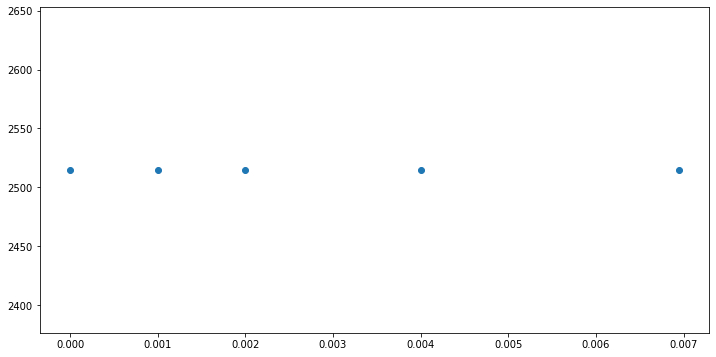

In [ ]:
sim_data_002_Q_peak_time = sim_time[sim_data_002_Q_peak_index]
sim_data_001_Q_peak_time = sim_time[sim_data_001_Q_peak_index]
sim_data_000_Q_peak_time = sim_time[sim_data_000_Q_peak_index]
sim_data_0069_Q_peak_time = sim_time[sim_data_0069_Q_peak_index]
sim_data_004_Q_peak_time = sim_time[sim_data_004_Q_peak_index]

Y = np.array([sim_data_002_Q_peak_time,
              sim_data_001_Q_peak_time,
              sim_data_000_Q_peak_time,
              sim_data_0069_Q_peak_time,
              sim_data_004_Q_peak_time])

plt.scatter(X, Y)
print(Y)

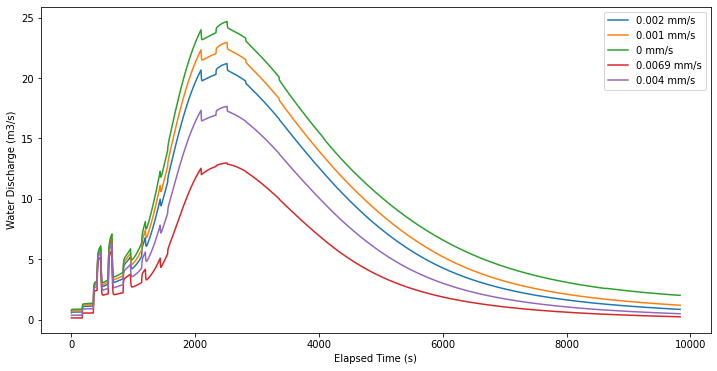

In [ ]:
plot_Q([
            sim_time
        ] * 5,
       [sim_data_002_Q * 1000,
        sim_data_001_Q * 1000,
        sim_data_000_Q * 1000,
        sim_data_0069_Q * 1000,
        sim_data_004_Q * 1000],
        [
                '0.002 mm/s',
                '0.001 mm/s',
                '0 mm/s',
                '0.0069 mm/s',
                '0.004 mm/s'
        ], xlabel="Elapsed Time (s)", ylabel=("Water Discharge (m3/s)"))



### Manning n

(7, 1968)
(7, 1968)


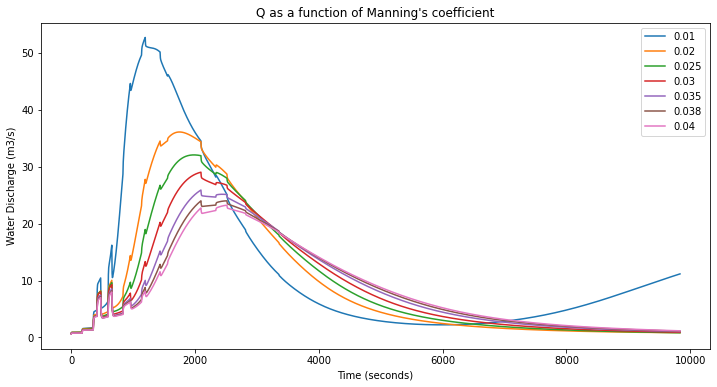

In [ ]:
data = [np.load(
    'run_data/SA-n-01.npz', allow_pickle=True),
np.load(
    'run_data/SA-n-02.npz', allow_pickle=True),
np.load(
    'run_data/SA-n-025.npz', allow_pickle=True),
np.load(
    'run_data/SA-n-03.npz', allow_pickle=True),
np.load(
    'run_data/SA-n-035.npz', allow_pickle=True),
np.load(
    'run_data/SA-n-038.npz', allow_pickle=True),
np.load(
    'run_data/SA-n-04.npz', allow_pickle=True)
]

manning_SA_Q = np.array([d['flume_runoff_m3_s'] for d in data]) * 1000
manning_SA_Q_n = [d['manning_n'] for d in data]
manning_SA_Q_iterations = [d['iterations'] for d in data]
manning_SA_Q_timestep = np.array([d['timestep_delta_s'] for d in data])
manning_SA_Q_duration = np.array(manning_SA_Q_iterations) * manning_SA_Q_timestep
manning_SA_Q_times = np.array([np.arange(manning_SA_Q.shape[1], dtype=np.float32) for _ in manning_SA_Q_iterations])

manning_SA_Q_times *= manning_SA_Q_duration[:, np.newaxis] / manning_SA_Q.shape[1]

print(manning_SA_Q_times.shape)
print(manning_SA_Q.shape)
plot_Q(manning_SA_Q_times, manning_SA_Q, labels=manning_SA_Q_n,
    title="Q as a function of Manning's coefficient",
    xlabel='Time (seconds)',
    ylabel="Water Discharge (m3/s)")



Text(0, 0.5, 'Peak discharge rate value (m3/s)')

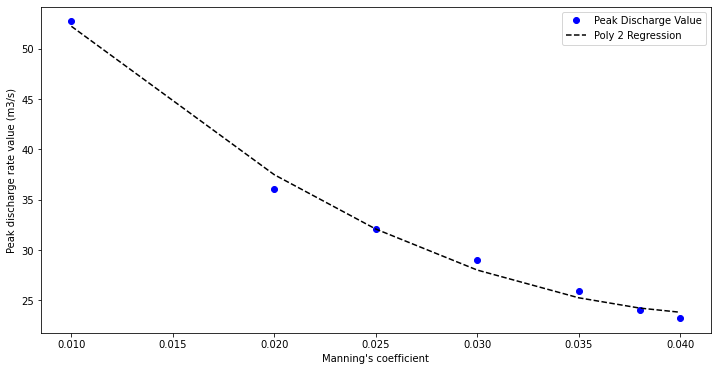

In [ ]:
Y = manning_SA_Q.max(axis = 1)
X = np.array(manning_SA_Q_n)
coef = np.polyfit(X, Y, 2)
poly1d_fn = np.polynomial.Polynomial(np.flip(coef))
plot_objs = plt.plot(X, Y, 'bo', X, poly1d_fn(X), '--k')
plt.legend(iter(plot_objs), ("Peak Discharge Value", 'Poly 2 Regression'))
plt.xlabel("Manning's coefficient")
plt.ylabel("Peak discharge rate value (m3/s)")


[-290619.83767866   56191.18724413     692.61516914]


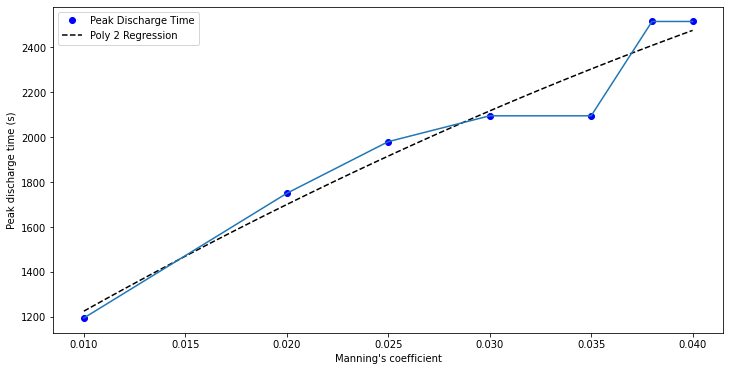

In [ ]:
manning_SA_Q_peak_time = np.take_along_axis(manning_SA_Q_times, np.argmax(manning_SA_Q, axis = 1)[:, None], axis = 1)

Y = manning_SA_Q_peak_time.reshape(manning_SA_Q_peak_time.shape[0])
X = np.array(manning_SA_Q_n)
rank = 2
coef = np.polyfit(X, Y, rank)
print(coef)
poly1d_fn = np.polynomial.Polynomial(np.flip(coef))
poly_x = np.linspace(X.min(), X.max(), num = 100)
plot_objs = plt.plot(X, Y, 'bo', poly_x, poly1d_fn(poly_x), '--k')
plt.legend(iter(plot_objs), ("Peak Discharge Time", f'Poly {rank} Regression'))
plt.xlabel("Manning's coefficient")
plt.ylabel("Peak discharge time (s)")
plt.plot(X, Y)


## Scenari alternativi

### 30/7/1981
Picco di 76.2 mm/h

In [ ]:
data = np.load('run_data/1981_7_3_038_man_p1.npz', allow_pickle=True)
simulated_Q_m3_s = data['flume_runoff_m3_s'] * 1000


watershed_id = data['watershed']
precipitation_event_date = data['event_date']
precipitation_event_start_time = data['event_start_time'].item()
delta_time = data['timestep_delta_s']
delta_space = data['dem_cell_size_m']
iterations = data['iterations']
manning_n = data['manning_n']
precipitation_coverage = data['precipitation_coverage']
infiltration_rate = data['infiltration_rate_mm_s']

simulation_duration = iterations * delta_time
simulated_Q_time = np.arange(
    simulated_Q_m3_s.shape[0]) * simulation_duration / simulated_Q_m3_s.shape[0]

simulation_parameters = SimulationParameters(
    watershed=watershed_id, event_date=precipitation_event_date,
    manning_n=manning_n, precipitation_coverage=precipitation_coverage,
    timestep_delta_s=delta_time, dem_cell_size_m=delta_space,
    infiltration_rate_mm_s=infiltration_rate)

print(simulation_parameters)



    Watershed: 11
    Event: 1981_7_30
    Manning N: 0.038
    Precipitation coverage: 0.8
    Delta t: 0.5
    Infiltration Rate (mm/s): 0.001
        


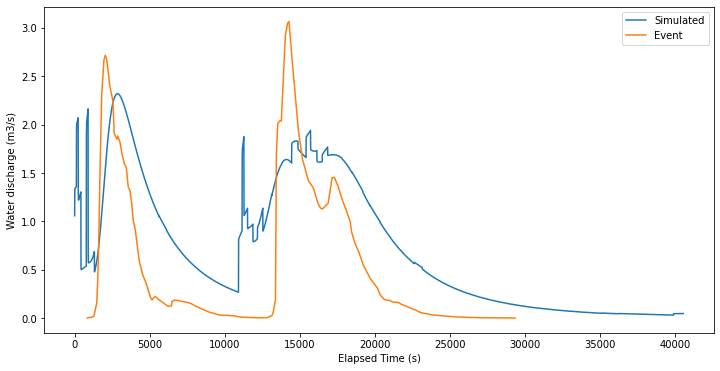

In [ ]:
runoff_data = pandas.read_csv(simulation_parameters.get_runoff_data_filename())
real_Q_m3_s = runoff_data['Runoff Rate (f3/s)'] * FEET3_S_TO_M3_S
real_Q_time_s = runoff_data['Elapsed Time'] * 60

hh,mm = list(map(int, runoff_data['Start Time'][0].split(':')))
real_start_time = time(hh, mm)
real_Q_time_s += compute_runoff_precipitation_time_diff_s(real_start_time, precipitation_event_start_time)


plot_Q([simulated_Q_time, real_Q_time_s], [simulated_Q_m3_s, real_Q_m3_s],
        ['Simulated', 'Event'], xlabel='Elapsed Time (s)',
        ylabel='Water discharge (m3/s)')





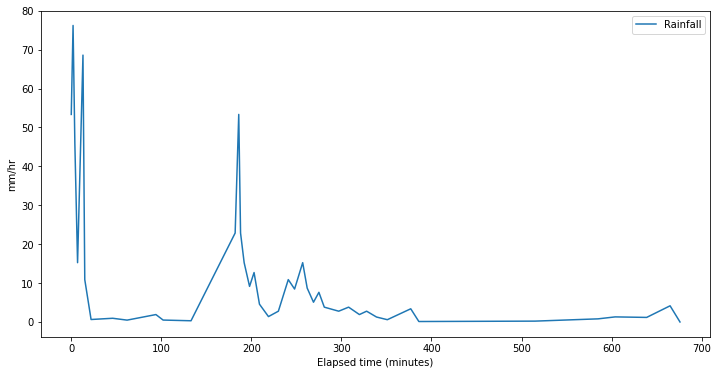

In [ ]:
rainfall_data = pandas.read_csv(simulation_parameters.get_rainfall_data_filename())
plt.plot(rainfall_data['Elapsed Time'], rainfall_data['Rainfall Rate (mm/hr)'], label='Rainfall')
plt.ylabel('mm/hr')
plt.xlabel('Elapsed time (minutes)')
plt.legend()

In [ ]:
data = np.load('run_data/2005_8_22.npz', allow_pickle=True)
simulated_Q_m3_s = data['flume_runoff_m3_s'] * 1000


watershed_id = data['watershed']
precipitation_event_date = data['event_date']
precipitation_event_start_time = data['event_start_time'].item()
delta_time = data['timestep_delta_s']
delta_space = data['dem_cell_size_m']
iterations = data['iterations']
manning_n = data['manning_n']
precipitation_coverage = data['precipitation_coverage']
infiltration_rate = data['infiltration_rate_mm_s']

simulation_duration = iterations * delta_time
simulated_Q_time = np.arange(
    simulated_Q_m3_s.shape[0]) * simulation_duration / simulated_Q_m3_s.shape[0]

simulation_parameters = SimulationParameters(
    watershed=watershed_id, event_date=precipitation_event_date,
    manning_n=manning_n, precipitation_coverage=precipitation_coverage,
    timestep_delta_s=delta_time, dem_cell_size_m=delta_space,
    infiltration_rate_mm_s=infiltration_rate)

print(simulation_parameters)


NameError: name 'np' is not defined

In [ ]:
runoff_data = pandas.read_csv(simulation_parameters.get_runoff_data_filename())
real_Q_m3_s = runoff_data['Runoff Rate (f3/s)'] * FEET3_S_TO_M3_S
real_Q_time_s = runoff_data['Elapsed Time'] * 60

hh, mm = list(map(int, runoff_data['Start Time'][0].split(':')))
real_start_time = time(hh, mm)
real_Q_time_s += compute_runoff_precipitation_time_diff_s(
    real_start_time, precipitation_event_start_time)


plot_Q([simulated_Q_time, real_Q_time_s], [simulated_Q_m3_s, real_Q_m3_s],
       ['Simulated', 'Event'], xlabel='Elapsed Time (s)',
       ylabel='Water discharge (m3/s)')


In [ ]:
rainfall_data = pandas.read_csv(
    simulation_parameters.get_rainfall_data_filename())
plt.plot(
    rainfall_data['Elapsed Time'],
    rainfall_data['Rainfall Rate (mm/hr)'],
    label='Rainfall')
plt.ylabel('mm/hr')
plt.xlabel('Elapsed time (minutes)')
plt.legend()
